In [1]:
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.indicators.gd import GD
from pymoo.indicators.igd import IGD
from pymoo.indicators.hv import HV
from pyrecorder.recorder import Recorder
from pyrecorder.writers.video import Video
from pymoo.visualization.fitness_landscape import FitnessLandscape
from pymoo.visualization.scatter import Scatter
import matplotlib.pyplot as plt
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from multiprocessing.pool import ThreadPool
from pymoo.core.problem import StarmapParallelization
from pymoo.core.callback import Callback
from pyrecorder.writers.streamer import Streamer
from pymoo.visualization.pcp import PCP
from pymoo.constraints.as_penalty import ConstraintsAsPenalty

In [3]:
class MyCallback(Callback):

    def __init__(self) -> None:
        super().__init__()
        self.rec = Recorder(Streamer(sleep=0.1))

    def notify(self, algorithm):
        problem = algorithm.problem

        pcp = PCP(title=("Gen %s" % algorithm.n_gen, {'pad': 30}),
                  bounds=(problem.xl, problem.xu),
                  labels=["$x_%s$" % k for k in range(problem.n_var)]
                  )
        pcp.set_axis_style(color="grey", alpha=0.5)

        pcp.add(algorithm.pop.get("X"), color="black", alpha=0.8, linewidth=1.5)
        if algorithm.off is not None:
            pcp.add(algorithm.off.get("X"), color="blue", alpha=0.8, linewidth=0.5)

        pcp.add(algorithm.opt.get("X"), color="red", linewidth=4)
        pcp.do()

        self.rec.record()


In [103]:

class ConstrainedProblem(ElementwiseProblem):

    def __init__(self, **kwargs):
        super().__init__(n_var=2, n_obj=1, n_ieq_constr=1, n_eq_constr=0, xl=0, xu=2, **kwargs)

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = x[0] ** 2 + x[1] ** 2
        out["G"] = 1.0 - (x[0] + x[1])

PSO:Best solution found: 
X = [1.         1.         1.         1.         1.         1.
 1.         1.         1.         2.99951936 2.99994819 2.99336537
 1.        ]
F = [-14.99283292]
CV = [0.]
Threads: 4.433530330657959
PF [-15.]
GD 0.0071670782074875206
IGD 0.0071670782074875206


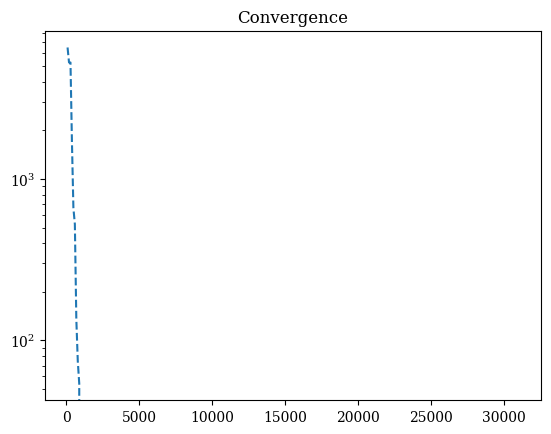

In [45]:

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.moo.sms import SMSEMOA
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.problems.single import Rastrigin

problem = get_problem("G1")


algorithm = SMSEMOA(pop_size=100)

res = minimize(ConstraintsAsPenalty(problem, penalty=100.0),
               algorithm,
               seed=1,
               save_history=True,
               verbose=False)

print("PSO:Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))
print('Threads:', res.exec_time)

pf = problem.pareto_front()
print("PF",pf[0])
ind = GD(pf)
print("GD", ind(res.F))
ind2 = IGD(pf)
print("IGD", ind2(res.F))


n_evals = np.array([e.evaluator.n_eval for e in res.history])
opt = np.array([e.opt[0].F for e in res.history])

plt.title("Convergence")
plt.plot(n_evals, opt, "--")
plt.plot(n_evals, np.repeat(pf[0],len(n_evals)), 'k-', lw=1,dashes=[2, 2])
plt.yscale("log")
plt.show()

GA:Best solution found: 
X = [1.         1.         1.         1.         1.         1.
 1.         1.         1.         2.99701306 2.99568996 2.99998792
 1.        ]
F = [-14.99269093]
Threads: 15.332735300064087
PF [-15.]
GD 59.42841829594486
IGD 59.42841829594486


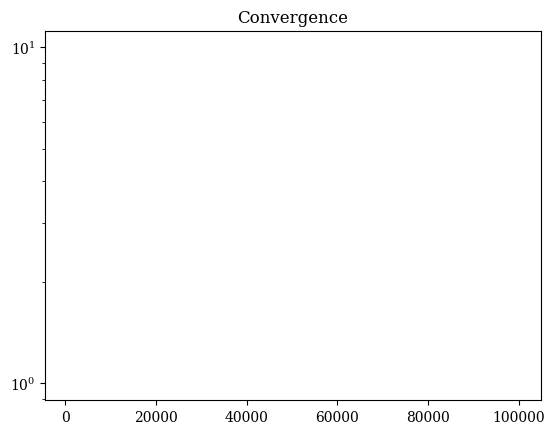

In [105]:
from pymoo.algorithms.soo.nonconvex.ga import GA

algorithm2 = GA(pop_size=500)

res2 = minimize(problem,
               algorithm2,
               seed=1,
               save_history=True,
               verbose=False)

print("GA:Best solution found: \nX = %s\nF = %s" % (res2.X, res2.F))
print('Threads:', res2.exec_time)

print("PF",pf[0])
print("GD", ind(res2.F))
print("IGD", ind2(res2.F))

n_evals2 = np.array([e.evaluator.n_eval for e in res2.history])
opt2 = np.array([e.opt[0].F for e in res2.history])

plt.title("Convergence")
plt.plot(n_evals2, opt2, "--")
plt.yscale("log")
plt.show()


UNSGA3: Best solution found: 
X = [1.         1.         1.         1.         1.         1.
 1.         1.         1.         2.99048993 2.97175718 2.99255741
 1.        ]
F = [-14.95480452]
Threads: 3.3989508152008057
PF [-15.]
GD 59.41694965273173
IGD 59.41694965273173


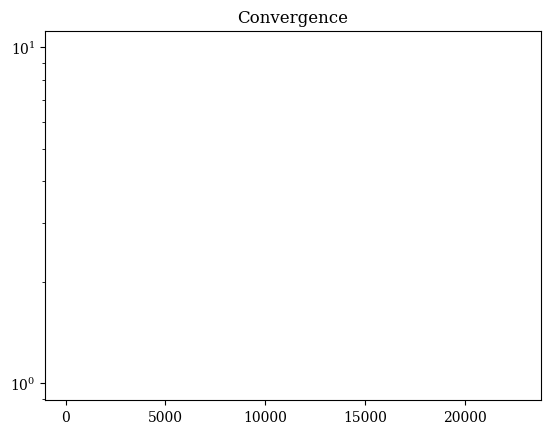

In [106]:
from pymoo.algorithms.moo.unsga3 import UNSGA3
ref_dirs = np.array([[1.0]])

# create the algorithm object
algorithm3 = UNSGA3(ref_dirs, pop_size=100)

# execute the optimization
res3 = minimize(problem,
               algorithm3,
               save_history=True,
               seed=1)

print("UNSGA3: Best solution found: \nX = %s\nF = %s" % (res3.X, res3.F))
print('Threads:', res3.exec_time)

print("PF",pf[0])

print("GD", ind(res3.F))

print("IGD", ind2(res3.F))

n_evals3 = np.array([e.evaluator.n_eval for e in res3.history])
opt3 = np.array([e.opt[0].F for e in res3.history])

plt.title("Convergence")
plt.plot(n_evals3, opt3, "--")
plt.yscale("log")
plt.show()

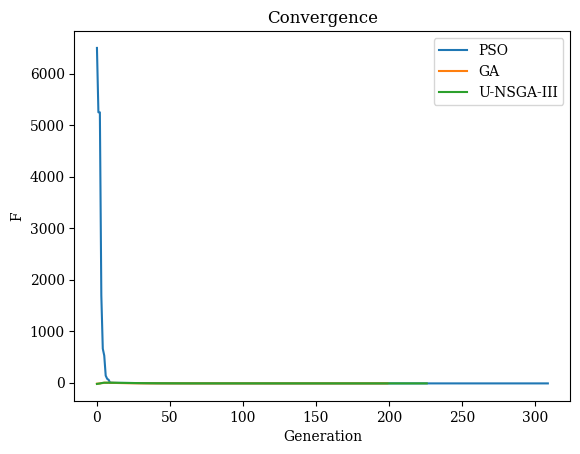

In [107]:
plt.plot(np.arange(len(res.history)), opt, label="PSO")
plt.plot(np.arange(len(res2.history)), opt2, label="GA")
plt.plot(np.arange(len(res3.history)), opt3, label="U-NSGA-III")
plt.title("Convergence")
plt.label("Generation")
plt.ylabel("F")
plt.legend()
plt.show()

In [108]:
from pymoo.core.problem import ElementwiseProblem
from multiprocessing.pool import ThreadPool
from pymoo.core.problem import StarmapParallelization
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
import pymoo.gradient.toolbox as anp

class MyProblem(ElementwiseProblem):

    def __init__(self, **kwargs):
        super().__init__(n_var=20, n_obj=1, n_ieq_constr=0, xl=-5, xu=5, **kwargs)

    def _evaluate(self, x, out, *args, **kwargs):
         out["F"] = (x ** 2).sum()

# initialize the thread pool and create the runner
n_threads = 4
pool = ThreadPool(n_threads)
runner = StarmapParallelization(pool.starmap)

# define the problem by passing the starmap interface of the thread pool
problem = MyProblem(elementwise_runner=runner)


res2 = minimize(problem, GA(), termination=("n_gen", 200), seed=1)
print('Threads:', res2.exec_time)

pool.close()

print("Best solution found: \nX = %s\nF = %s" % (res2, res2.F))
print('Threads:', res2.exec_time)
pf = get_problem("Rastrigin").pareto_front()

ind = GD(pf)
print("GD", ind(res2))
ind2 = IGD(pf)
print("IGD", ind2(res2))

problem2 = MyProblem()
res2 = minimize(problem2, GA(), termination=("n_gen", 200), seed=1)
print('Threads:', res2.exec_time)

Threads: 1.1049034595489502
Best solution found: 
X = [-1.84454184e-03 -3.07855265e-07 -1.84083883e-03 -2.55294717e-03
  1.21220024e-04 -3.49845921e-04  1.95880478e-03  3.77647259e-03
  8.75012245e-04  6.09764405e-03  1.52411796e-03  4.16973334e-03
  2.92235697e-03 -5.93120277e-04  1.54744547e-04  3.13440708e-03
  8.93193580e-04  3.69947553e-03 -4.32435083e-03 -7.59810588e-04]
F = [0.0001417]
Threads: 1.1049034595489502
GD 0.011903885171949834
IGD 0.011903885171949834
Threads: 1.079477310180664


In [109]:
from pymoo.core.problem import Problem
from multiprocessing.pool import ThreadPool
from pymoo.core.problem import StarmapParallelization
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize

class MyProblem(Problem):

    def __init__(self, **kwargs):
        super().__init__(n_var=10, n_obj=1, n_ieq_constr=0, xl=-5, xu=5, **kwargs)

    def _evaluate(self, x, out, *args, **kwargs):
         out["F"] = np.sum((x  ** 2), axis=1)

problem2 = MyProblem()

res = minimize(problem2, PSO(pop_size=3000), seed=1, verbose = True, n_gen= 100)
print('Threads:', res.exec_time)
print("Best solution found: \nX = %s\nF = %s" % (res, res.F))

n_gen  |  n_eval  |    f     |    S    |    w    |    c1    |    c2    |     f_avg     |     f_min    
     1 |     3000 |        - |       - |  0.9000 |  2.00000 |  2.00000 |  8.333308E+01 |  1.870006E+01
     2 |     6000 |  0.13389 |       3 |  0.4857 |  2.00000 |  2.01953 |  3.246468E+01 |  2.6685883458
     3 |     9000 |  0.02016 |       3 |  0.4126 |  1.99040 |  2.02685 |  9.9213786613 |  0.8001720472
     4 |    12000 | -2.5E-04 |       3 |  0.3998 |  1.98219 |  2.04072 |  5.8030968479 |  0.8001720472
     5 |    15000 | -2.5E-04 |       3 |  0.3998 |  1.97150 |  2.05503 |  3.9699141518 |  0.4662020022


: 

: 

In [ ]:
from pymoo.core.problem import ElementwiseProblem
class MyProblem2(ElementwiseProblem):

    def __init__(self, **kwargs):
        super().__init__(n_var=10, n_obj=1, n_ieq_constr=0, xl=-5, xu=5, **kwargs)

    def _evaluate(self, x, out, *args, **kwargs):
         out["F"] = (x ** 2).sum()

In [ ]:

# initialize the thread pool and create the runner
n_threads = 8
pool = ThreadPool(n_threads)
runner = StarmapParallelization(pool.starmap)

# define the problem by passing the starmap interface of the thread pool
problem3 = MyProblem2(elementwise_runner=runner)

res = minimize(problem3, PSO(pop_size=3000), seed=1, verbose = True,n_gen= 100)
print('Threads:', res.exec_time)
print("Best solution found: \nX = %s\nF = %s" % (res, res.F))
pool.close()

In [ ]:
import multiprocessing
n_proccess = 8
pool = multiprocessing.Pool(n_proccess)
runner = StarmapParallelization(pool.starmap)
problem4 = MyProblem2(elementwise_runner=runner)
res = minimize(problem4, PSO(pop_size=3000), seed=1, n_gen= 100)
print('Threads:', res.exec_time)
pool.close()

In [ ]:
from dask.distributed import Client
from pymoo.core.problem import DaskParallelization
client = Client()
client.restart()
print("DASK STARTED")

# initialize the thread pool and create the runner
runner = DaskParallelization(client)


# define the problem by passing the starmap interface of the thread pool
problem5 = MyProblem2(elementwise_runner=runner)

res = minimize(problem5, PSO(pop_size=3000), seed=1, n_gen= 100)
print('Threads:', res.exec_time)

client.close()
print("DASK SHUTDOWN")

In [ ]:
from pymoo.algorithms.moo.unsga3 import UNSGA3
ref_dirs = np.array([[1.0]])

# execute the optimization
res2 = minimize(problem2,
               UNSGA3(ref_dirs, pop_size=100),
               seed=1)

print("Best solution found: \nX = %s\nF = %s" % (res2, res2.F))
print('Threads:', res2.exec_time)
pf = get_problem("Rastrigin").pareto_front()

ind = GD(pf)
print("GD", ind(res2))
ind2 = IGD(pf)
print("IGD", ind2(res2))


In [ ]:
import pandas as pd
import numpy as np
from pymoo.util.remote import Remote

file = Remote.get_instance().load("examples", "portfolio_allocation.csv", to=None)
df = pd.read_csv(file, parse_dates=True, index_col="date")
returns = df.pct_change().dropna(how="all")
mu = (1 + returns).prod() ** (252 / returns.count()) - 1
cov = returns.cov() * 252

mu, cov = mu.to_numpy(), cov.to_numpy()

In [ ]:
class PortfolioProblem(ElementwiseProblem):

    def __init__(self, mu, cov, risk_free_rate=0.02, **kwargs):
        super().__init__(n_var=len(df.columns), n_obj=2, xl=0.0, xu=1.0, **kwargs)
        self.mu = mu
        self.cov = cov
        self.risk_free_rate = risk_free_rate

    def _evaluate(self, x, out, *args, **kwargs):
        exp_return = x @ self.mu
        exp_risk = np.sqrt(x.T @ self.cov @ x)
        sharpe = (exp_return - self.risk_free_rate) / exp_risk

        out["F"] = [exp_risk, -exp_return]
        out["sharpe"] = sharpe

In [ ]:
from pymoo.core.repair import Repair

class PortfolioRepair(Repair):

    def _do(self, problem, X, **kwargs):
        X[X < 1e-3] = 0
        return X / X.sum(axis=1, keepdims=True)

In [46]:
problem = get_problem("dtlz1")

In [2]:
from pymoo.algorithms.moo.sms import SMSEMOA
from pymoo.optimize import minimize

#problem = PortfolioProblem(mu, cov)
"x = np.array([1.0, 1.0])"
"ref_dirs = np.repeat(x,20, axis=1)"
algorithm1 = SMSEMOA(repair=None)

res1 = minimize(problem,
               algorithm1,
               seed=1,
               save_history=True,
               verbose=False)

KeyboardInterrupt: 

In [3]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

algorithm2 = NSGA2(pop_size=100)

res2 = minimize(problem,
               algorithm2,
               seed=1,
               save_history=True,
               verbose=False)

KeyboardInterrupt: 

In [37]:
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.optimize import minimize
from pymoo.util.ref_dirs import get_reference_directions

ref_dirs = get_reference_directions("uniform", 3, n_partitions=12)

algorithm3 = NSGA3(ref_dirs,pop_size=100)

res3 = minimize(problem,
               algorithm3,
               seed=1,
               save_history=True,
               verbose=False)

In [29]:
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.optimize import minimize

algorithm4 = MOEAD(
    ref_dirs,
    n_neighbors=15,
    prob_neighbor_mating=0.7)

res4 = minimize(problem,
               algorithm4,
               save_history=True,
               seed=1,
               verbose=False)

In [30]:
from pymoo.algorithms.moo.ctaea import CTAEA
from pymoo.optimize import minimize


algorithm5 = CTAEA(ref_dirs=ref_dirs)

res5 = minimize(problem,
               algorithm5,
               save_history=True,
               seed=1,
               verbose=False)

In [31]:
from pymoo.algorithms.moo.rvea import RVEA

algorithm6 = RVEA(ref_dirs)

res6 = minimize(problem,
               algorithm6,
               termination=('n_gen', 400),
               save_history=True,
               seed=1,
               verbose=False)

In [32]:
from pymoo.algorithms.moo.unsga3 import UNSGA3
from pymoo.optimize import minimize
from pymoo.util.ref_dirs import get_reference_directions

ref_dirs = get_reference_directions("uniform", 3, n_partitions=12)

algorithm7 = UNSGA3(ref_dirs,pop_size=100)

res7 = minimize(problem,
               algorithm7,
               save_history=True,
               seed=1,
               verbose=False)

In [66]:
pf = get_problem("dtlz1").pareto_front()

ind = GD(pf)
ind2 = IGD(pf)
ref_point = np.array([1.2, 1.2,1.2])
ind3 = HV(ref_point=ref_point)

result_list = [res3.F,res4.F,res5.F,res6.F,res7.F]
GD_list = [ind(i) for i in result_list]
IGD_list = [ind2(i) for i in result_list]
HV_list = [ind3(i) for i in result_list]

GD_list.sort()
IGD_list.sort()
HV_list.sort()

print(*GD_list)
print("NSGA-III GD", ind(res3.F))
print("NSGA-III IGD:", ind2(res3.F))
print("NSGA-III HV", ind3(res3.F))

print("MOEAD GD", ind(res4.F))
print("MOEAD IGD:", ind2(res4.F))
print("MOEAD HV", ind3(res4.F))

print("CTEA GD", ind(res5.F))
print("CTEA IGD:", ind2(res5.F))
print("CTEA HV", ind3(res5.F))

print("RVEA GD", ind(res6.F))
print("RVEA IGD:", ind2(res6.F))
print("RVEA HV:", ind3(res6.F))

print("U-NSGA-III GD", ind(res7.F))
print("U-NSGA-III IGD:", ind2(res7.F))
print("U-NSGA-III HV:", ind3(res7.F))



0.015173650744802153 0.015297317315442212 0.01538445297784085 0.015424472642293996 0.020941833584052032
NSGA-III GD 0.015297317315442212
NSGA-III IGD: 0.019500012668981343
NSGA-III HV 1.7014881505798458
MOEAD GD 0.020941833584052032
MOEAD IGD: 0.02445089653099348
MOEAD HV 1.6965866627476793
CTEA GD 0.015173650744802153
CTEA IGD: 0.019454038447554674
CTEA HV 1.7014305478362923
RVEA GD 0.01538445297784085
RVEA IGD: 0.019613448434132652
RVEA HV: 1.7015379445000738
U-NSGA-III GD 0.015424472642293996
U-NSGA-III IGD: 0.01962258567615574
U-NSGA-III HV: 1.70127451331249


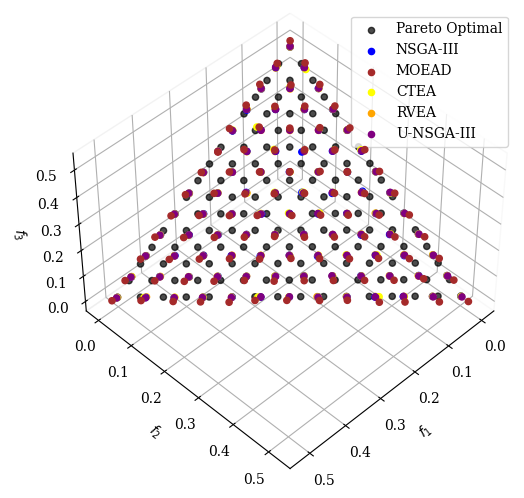

In [67]:
plot = Scatter(legend = True)
plot.add(problem.pareto_front(),  color="black", alpha=0.7, label="Pareto Optimal")
#plot.add(res1.F, color="red", label="SMS-EMOA")
#plot.add(res2.F, color="green", label="NSGA-II")
plot.add(res3.F, color="blue", label="NSGA-III")
plot.add(res4.F, color="brown", label="MOEAD")
plot.add(res5.F, color="yellow", label="CTEA")
plot.add(res6.F, color="orange", label="RVEA")
plot.add(res7.F, color="purple", label="U-NSGA-III")
plot.show()

NameError: name 'cov' is not defined

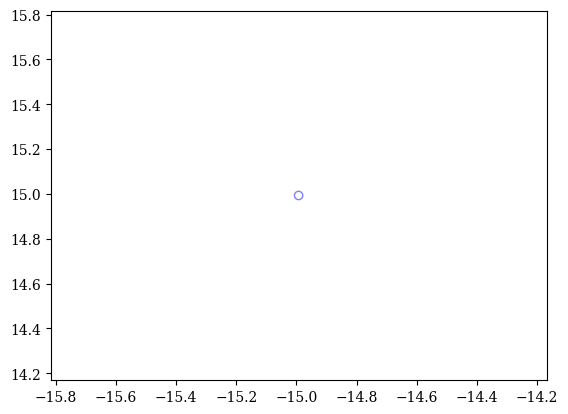

In [68]:
X, F, sharpe = res.opt.get("X", "F", "sharpe")
F = F * [1, -1]
max_sharpe = sharpe.argmax()

plt.scatter(F[:, 0], F[:, 1], facecolor="none", edgecolors="blue", alpha=0.5, label="Pareto-Optimal Portfolio")
plt.scatter(cov.diagonal() ** 0.5, mu, facecolor="none", edgecolors="black", s=30, label="Asset")
plt.scatter(F[max_sharpe, 0], F[max_sharpe, 1], marker="x", s=100, color="red", label="Max Sharpe Portfolio")
plt.legend()
plt.xlabel("expected volatility")
plt.ylabel("expected return")
plt.show()

In [69]:
import operator

allocation = {name: w for name, w in zip(df.columns, X[max_sharpe])}
allocation = sorted(allocation.items(), key=operator.itemgetter(1), reverse=True)

print("Allocation With Best Sharpe")
for name, w in allocation:
    print(f"{name:<5} {w}")

NameError: name 'df' is not defined